- case3: sleep 파생변수 추가

In [212]:
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

In [213]:
import pandas as pd
import numpy as np
from datetime import datetime
import pickle
import os
import warnings

warnings.filterwarnings("ignore")

In [214]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [215]:
n_splits = 3
random_seed = 2025

# Data

In [216]:
train_sleep_file_path = "../data/train/raw/train_sleep.csv"
train_activity_file_path = "../data/train/raw/train_activity.csv"
train_label_file_path = "../data/train/label/sleep/training_label.csv"

test_sleep_file_path = "../data/validation/raw/val_sleep.csv"
test_activity_file_path = "../data/validation/raw/val_activity.csv"
test_label_file_path = "../data/validation/label/sleep/val_label.csv"

train_derived_file_path = "../data/derived_var/train_add.csv"
test_derived_file_path = "../data/derived_var/test_add.csv"

train2_derived_file_path = "../data/derived_var/bong_train.csv"
test2_derived_file_path = "../data/derived_var/bong_test.csv"

train3_derived_file_path = "../data/derived_var/sleep_train_add.csv"
test3_derived_file_path = "../data/derived_var/sleep_test_add.csv"

In [217]:
train_label = pd.read_csv(train_label_file_path)
train_sleep = pd.read_csv(train_sleep_file_path)
train_activity = pd.read_csv(train_activity_file_path)

test_label = pd.read_csv(test_label_file_path)
test_sleep = pd.read_csv(test_sleep_file_path)
test_activity = pd.read_csv(test_activity_file_path)

train_derived = pd.read_csv(train_derived_file_path)
test_derived = pd.read_csv(test_derived_file_path)

train_derived2 = pd.read_csv(train2_derived_file_path)
test_derived2 = pd.read_csv(test2_derived_file_path)
test_derived2.drop(["Unnamed: 0"], inplace=True, axis=1)

train_derived3 = pd.read_csv(train3_derived_file_path)
test_derived3 = pd.read_csv(test3_derived_file_path)

In [218]:
# train, test email exclusive 확인
common_elements = list(
    set(train_label["SAMPLE_EMAIL"]) & set(test_label["SAMPLE_EMAIL"])
)
len(common_elements)

0

In [219]:
# sleep + label
train = train_sleep.merge(train_label, left_on="EMAIL", right_on="SAMPLE_EMAIL")
test = test_sleep.merge(test_label, left_on="EMAIL", right_on="SAMPLE_EMAIL")
train.drop(["SAMPLE_EMAIL"], axis=1, inplace=True)
test.drop(["SAMPLE_EMAIL"], axis=1, inplace=True)

# sleep + activity
train = pd.concat([train, train_activity.drop(["EMAIL"], axis=1)], axis=1)
test = pd.concat([test, test_activity.drop(["EMAIL"], axis=1)], axis=1)

In [220]:
train["activity_date"] = pd.to_datetime(train["activity_day_start"]).dt.date.astype(str)
test["activity_date"] = pd.to_datetime(test["activity_day_start"]).dt.date.astype(str)

In [221]:
train = train.merge(train_derived3, on=["EMAIL", "activity_date"], how="inner")
test = test.merge(test_derived3, on=["EMAIL", "activity_date"], how="inner")

In [222]:
for col in train.columns:
    if "_x" in col:
        train.drop([col], axis=1, inplace=True)
        train.rename(
            columns={col.replace("_x", "_y"): col.replace("_x", "")}, inplace=True
        )
    if "avg_" in col:
        train.drop([col], axis=1, inplace=True)
    if "std_" in col:
        train.drop([col], axis=1, inplace=True)

for col in test.columns:
    if "_x" in col:
        test.drop([col], axis=1, inplace=True)
        test.rename(
            columns={col.replace("_x", "_y"): col.replace("_x", "")}, inplace=True
        )
    if "avg_" in col:
        test.drop([col], axis=1, inplace=True)
    if "std_" in col:
        test.drop([col], axis=1, inplace=True)

In [223]:
label_encoder = {"CN": 0, "MCI": 1, "Dem": 2}

In [224]:
train["label"] = train["DIAG_NM"].map(label_encoder)
test["label"] = test["DIAG_NM"].map(label_encoder)
train.drop(["DIAG_NM"], axis=1, inplace=True)
test.drop(["DIAG_NM"], axis=1, inplace=True)

# train + test

In [225]:
all_data = pd.concat([train, test], axis=0)
all_data = all_data.drop(["label"], axis=1)  # 타겟값 제거

# feature selection

In [226]:
drop_features = [
    "sleep_period_id",
    "sleep_is_longest",
    "sleep_temperature_delta",
    "sleep_temperature_deviation",
    "sleep_midpoint_time",
    "activity_inactivity_alerts",
    "sleep_total",
    # low importance,
    "deep_ratio_5h_lag2",
    "deep_ratio_5h_3d_avg",
    "deep_ratio_5h_30d_avg",
    "deep_ratio_5h",
    "awake_ratio_5h_3d_avg",
    "awake_ratio_5h",
    "hr_pattern_5",
    "sleep_end_weekday",
    "hr_pattern_0",
]

all_data = all_data[all_data.columns.difference(drop_features)]

all_data = all_data.select_dtypes(include=[int, float])  # 숫자형 데이터만
selected_features = all_data.columns

selected_features.values, len(selected_features)  # original = 51

(array(['activity_average_met', 'activity_cal_active',
        'activity_cal_total', 'activity_daily_movement', 'activity_high',
        'activity_inactive', 'activity_low', 'activity_medium',
        'activity_met_min_high', 'activity_met_min_inactive',
        'activity_met_min_low', 'activity_met_min_medium',
        'activity_non_wear', 'activity_rest', 'activity_score',
        'activity_score_meet_daily_targets',
        'activity_score_move_every_hour', 'activity_score_recovery_time',
        'activity_score_stay_active', 'activity_score_training_frequency',
        'activity_score_training_volume', 'activity_steps',
        'activity_total', 'awake_longest_duration_lag2', 'hr_pattern_3',
        'sleep_awake', 'sleep_breath_average', 'sleep_consistency',
        'sleep_consistency_30d_avg', 'sleep_deep', 'sleep_deep_ratio',
        'sleep_duration', 'sleep_efficiency', 'sleep_end_hour',
        'sleep_hr_average', 'sleep_hr_lowest', 'sleep_hr_lowest_lag2',
        'sleep_light'

# 데이터 다운캐스팅

In [227]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2  # 1MB = 1024**2 Byte
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == "object":
            pass
        elif dtype_name == "bool":
            df[col] = df[col].astype("int8")
        elif dtype_name.startswith("int") or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast="integer")
        else:
            df[col] = pd.to_numeric(df[col], downcast="float")
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print("{:.1f}% 압축됨".format(100 * (start_mem - end_mem) / start_mem))

    return df


all_data = downcast(all_data)

71.2% 압축됨


# 데이터 나누기

In [228]:
merged_df = pd.concat([all_data, train[["EMAIL", "label"]]], axis=1)

X_test = merged_df.loc[test.index, selected_features]
y_test = merged_df.loc[test.index, "label"]

merged_df = merged_df.loc[: train.index[-1]]

In [229]:
merged_df.shape, X_test.shape, y_test.shape

((9705, 57), (4956, 55), (4956,))

# DIAG_NM(label) 비율

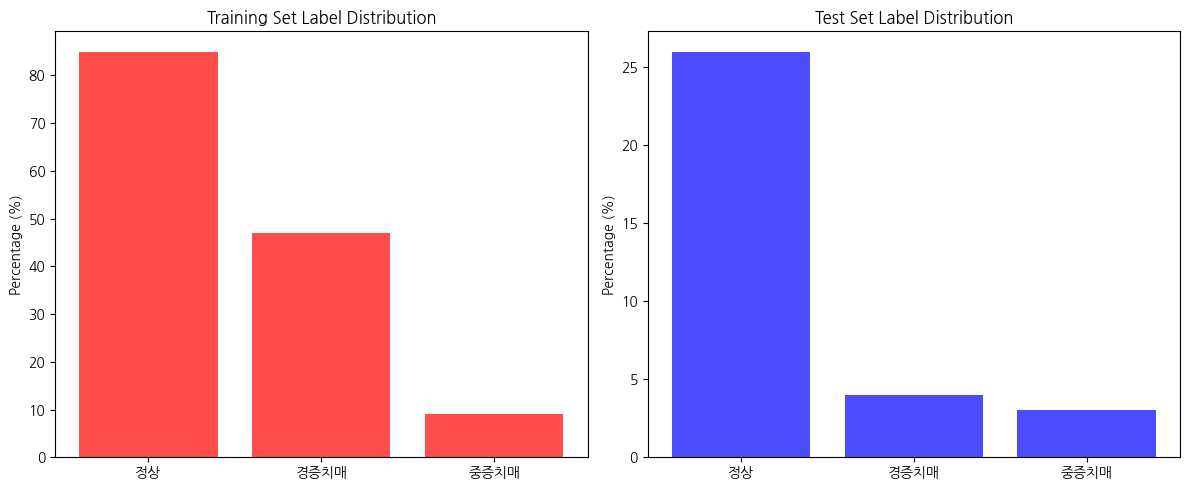

In [230]:
import matplotlib.pyplot as plt

class_distribution_train = train_label["DIAG_NM"].value_counts()
class_distribution_test = test_label["DIAG_NM"].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(
    class_distribution_train.index,
    class_distribution_train.values,
    color="red",
    alpha=0.7,
)
axes[0].set_xlabel(None)
axes[0].set_ylabel("Percentage (%)")
axes[0].set_title("Training Set Label Distribution")
axes[0].set_xticks([0, 1, 2], ["정상", "경증치매", "중증치매"])

axes[1].bar(
    class_distribution_test.index,
    class_distribution_test.values,
    color="blue",
    alpha=0.7,
)
axes[1].set_xlabel(None)
axes[1].set_ylabel("Percentage (%)")
axes[1].set_title("Test Set Label Distribution")
axes[1].set_xticks([0, 1, 2], ["정상", "경증치매", "중증치매"])

plt.tight_layout()
plt.show()

# 모델 학습 및 성능 검증

In [231]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# 모델 학습 및 평가
models = {
    "Gradient Boosting": GradientBoostingClassifier(
        random_state=random_seed,
    ),
    "Random Forest": RandomForestClassifier(random_state=random_seed, n_jobs=-1),
}

In [232]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report


def evaluate_model(name, model, merged_df, n_splits=n_splits):
    acc_scores = []
    f1_scores = []
    class_report_list = []
    folds = []

    # unique EMAIL, label 쌍 추출
    unique_patient_labels = merged_df[["EMAIL", "label"]].drop_duplicates()

    # StratifiedKFold를 사용하여 라벨 비율을 유지하면서 Fold를 생성
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

    for fold_idx, (train_idx, val_idx) in enumerate(
        skf.split(unique_patient_labels["EMAIL"], unique_patient_labels["label"])
    ):
        # 학습/검증 데이터 이메일 리스트 추출
        train_emails = unique_patient_labels.iloc[train_idx]["EMAIL"]
        val_emails = unique_patient_labels.iloc[val_idx]["EMAIL"]

        # 이메일 기준으로 원본 데이터에서 train/validation 데이터 생성
        X_train = merged_df[merged_df["EMAIL"].isin(train_emails)].copy()
        X_val = merged_df[merged_df["EMAIL"].isin(val_emails)].copy()

        y_train = X_train["label"]
        y_val = X_val["label"]
        X_train.drop(["EMAIL", "label"], axis=1, inplace=True)
        X_val.drop(["EMAIL", "label"], axis=1, inplace=True)

        # 모델 학습
        model.fit(X_train, y_train)

        # 모델 예측
        y_pred = model.predict(X_val)

        # 평가
        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average="weighted")  # 불균형 데이터 고려
        acc_scores.append(acc)
        f1_scores.append(f1)

        # Classification Report 저장
        report = classification_report(y_val, y_pred, output_dict=True)
        class_report_list.append(pd.DataFrame(report).T)

        folds.append((X_train, X_val, y_train, y_val))

    # Classification Report 평균
    avg_class_report = pd.concat(class_report_list).groupby(level=0).mean()

    # Accuracy 및 F1-score 평균 출력
    print("#" * 40, f"Model: {name}", "#" * 40)
    print(f"=== Average Classification Report ===")
    print(avg_class_report)
    print(f"Average Accuracy: {np.mean(acc_scores):.4f}")
    print(f"Average F1-score: {np.mean(f1_scores):.4f}")
    print("=" * 60)

    return name, model, folds


models_ = {}
folds_ = {}

# 모델별 평가 실행
for name, model in models.items():
    name_, model_, fold_ = evaluate_model(name, model, merged_df)
    models_[name] = model_
    folds_[name] = fold_

######################################## Model: Gradient Boosting ########################################
=== Average Classification Report ===
              precision    recall  f1-score      support
0              0.608433  0.778905  0.681634  1927.000000
1              0.414024  0.260402  0.312902  1117.666667
2              0.454053  0.091577  0.130426   190.333333
accuracy       0.557907  0.557907  0.557907     0.557907
macro avg      0.492170  0.376961  0.374987  3235.000000
weighted avg   0.534181  0.557907  0.522186  3235.000000
Average Accuracy: 0.5579
Average F1-score: 0.5222
######################################## Model: Random Forest ########################################
=== Average Classification Report ===
              precision    recall  f1-score      support
0              0.593705  0.803525  0.681159  1927.000000
1              0.376268  0.196695  0.251962  1117.666667
2              0.534870  0.046416  0.077418   190.333333
accuracy       0.547229  0.547229  0.

# Test dataset 예측 결과

In [233]:
# Test Set 성능 평가
print("\n", "=" * 40, "TEST SET EVALUATION", "=" * 40, "\n")

for name, model in models_.items():
    print(f"=== Evaluating {name} on Test Set ===")

    # 테스트 데이터 예측
    y_test_pred = model.predict(X_test)

    # 테스트 데이터 평가
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average="weighted")  # 불균형 고려
    test_report = classification_report(y_test, y_test_pred, output_dict=True)

    # 결과 출력
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test F1-score: {test_f1:.4f}")
    print(f"Test Classification Report:\n", pd.DataFrame(test_report).T)
    print("=" * 60)


 ======================================== TEST SET EVALUATION ======================================== 

=== Evaluating Gradient Boosting on Test Set ===
Test Accuracy: 0.5700
Test F1-score: 0.5566
Test Classification Report:
               precision    recall  f1-score      support
0              0.583155  0.735135  0.650384  2590.000000
1              0.508553  0.410733  0.454439  1882.000000
2              0.865497  0.305785  0.451908   484.000000
accuracy       0.570016  0.570016  0.570016     0.570016
macro avg      0.652401  0.483885  0.518910  4956.000000
weighted avg   0.582399  0.570016  0.556592  4956.000000
=== Evaluating Random Forest on Test Set ===
Test Accuracy: 0.6273
Test F1-score: 0.6190
Test Classification Report:
               precision    recall  f1-score     support
0              0.621497  0.779151  0.691451  2590.00000
1              0.579127  0.451116  0.507168  1882.00000
2              0.995885  0.500000  0.665750   484.00000
accuracy       0.627320  0.6273

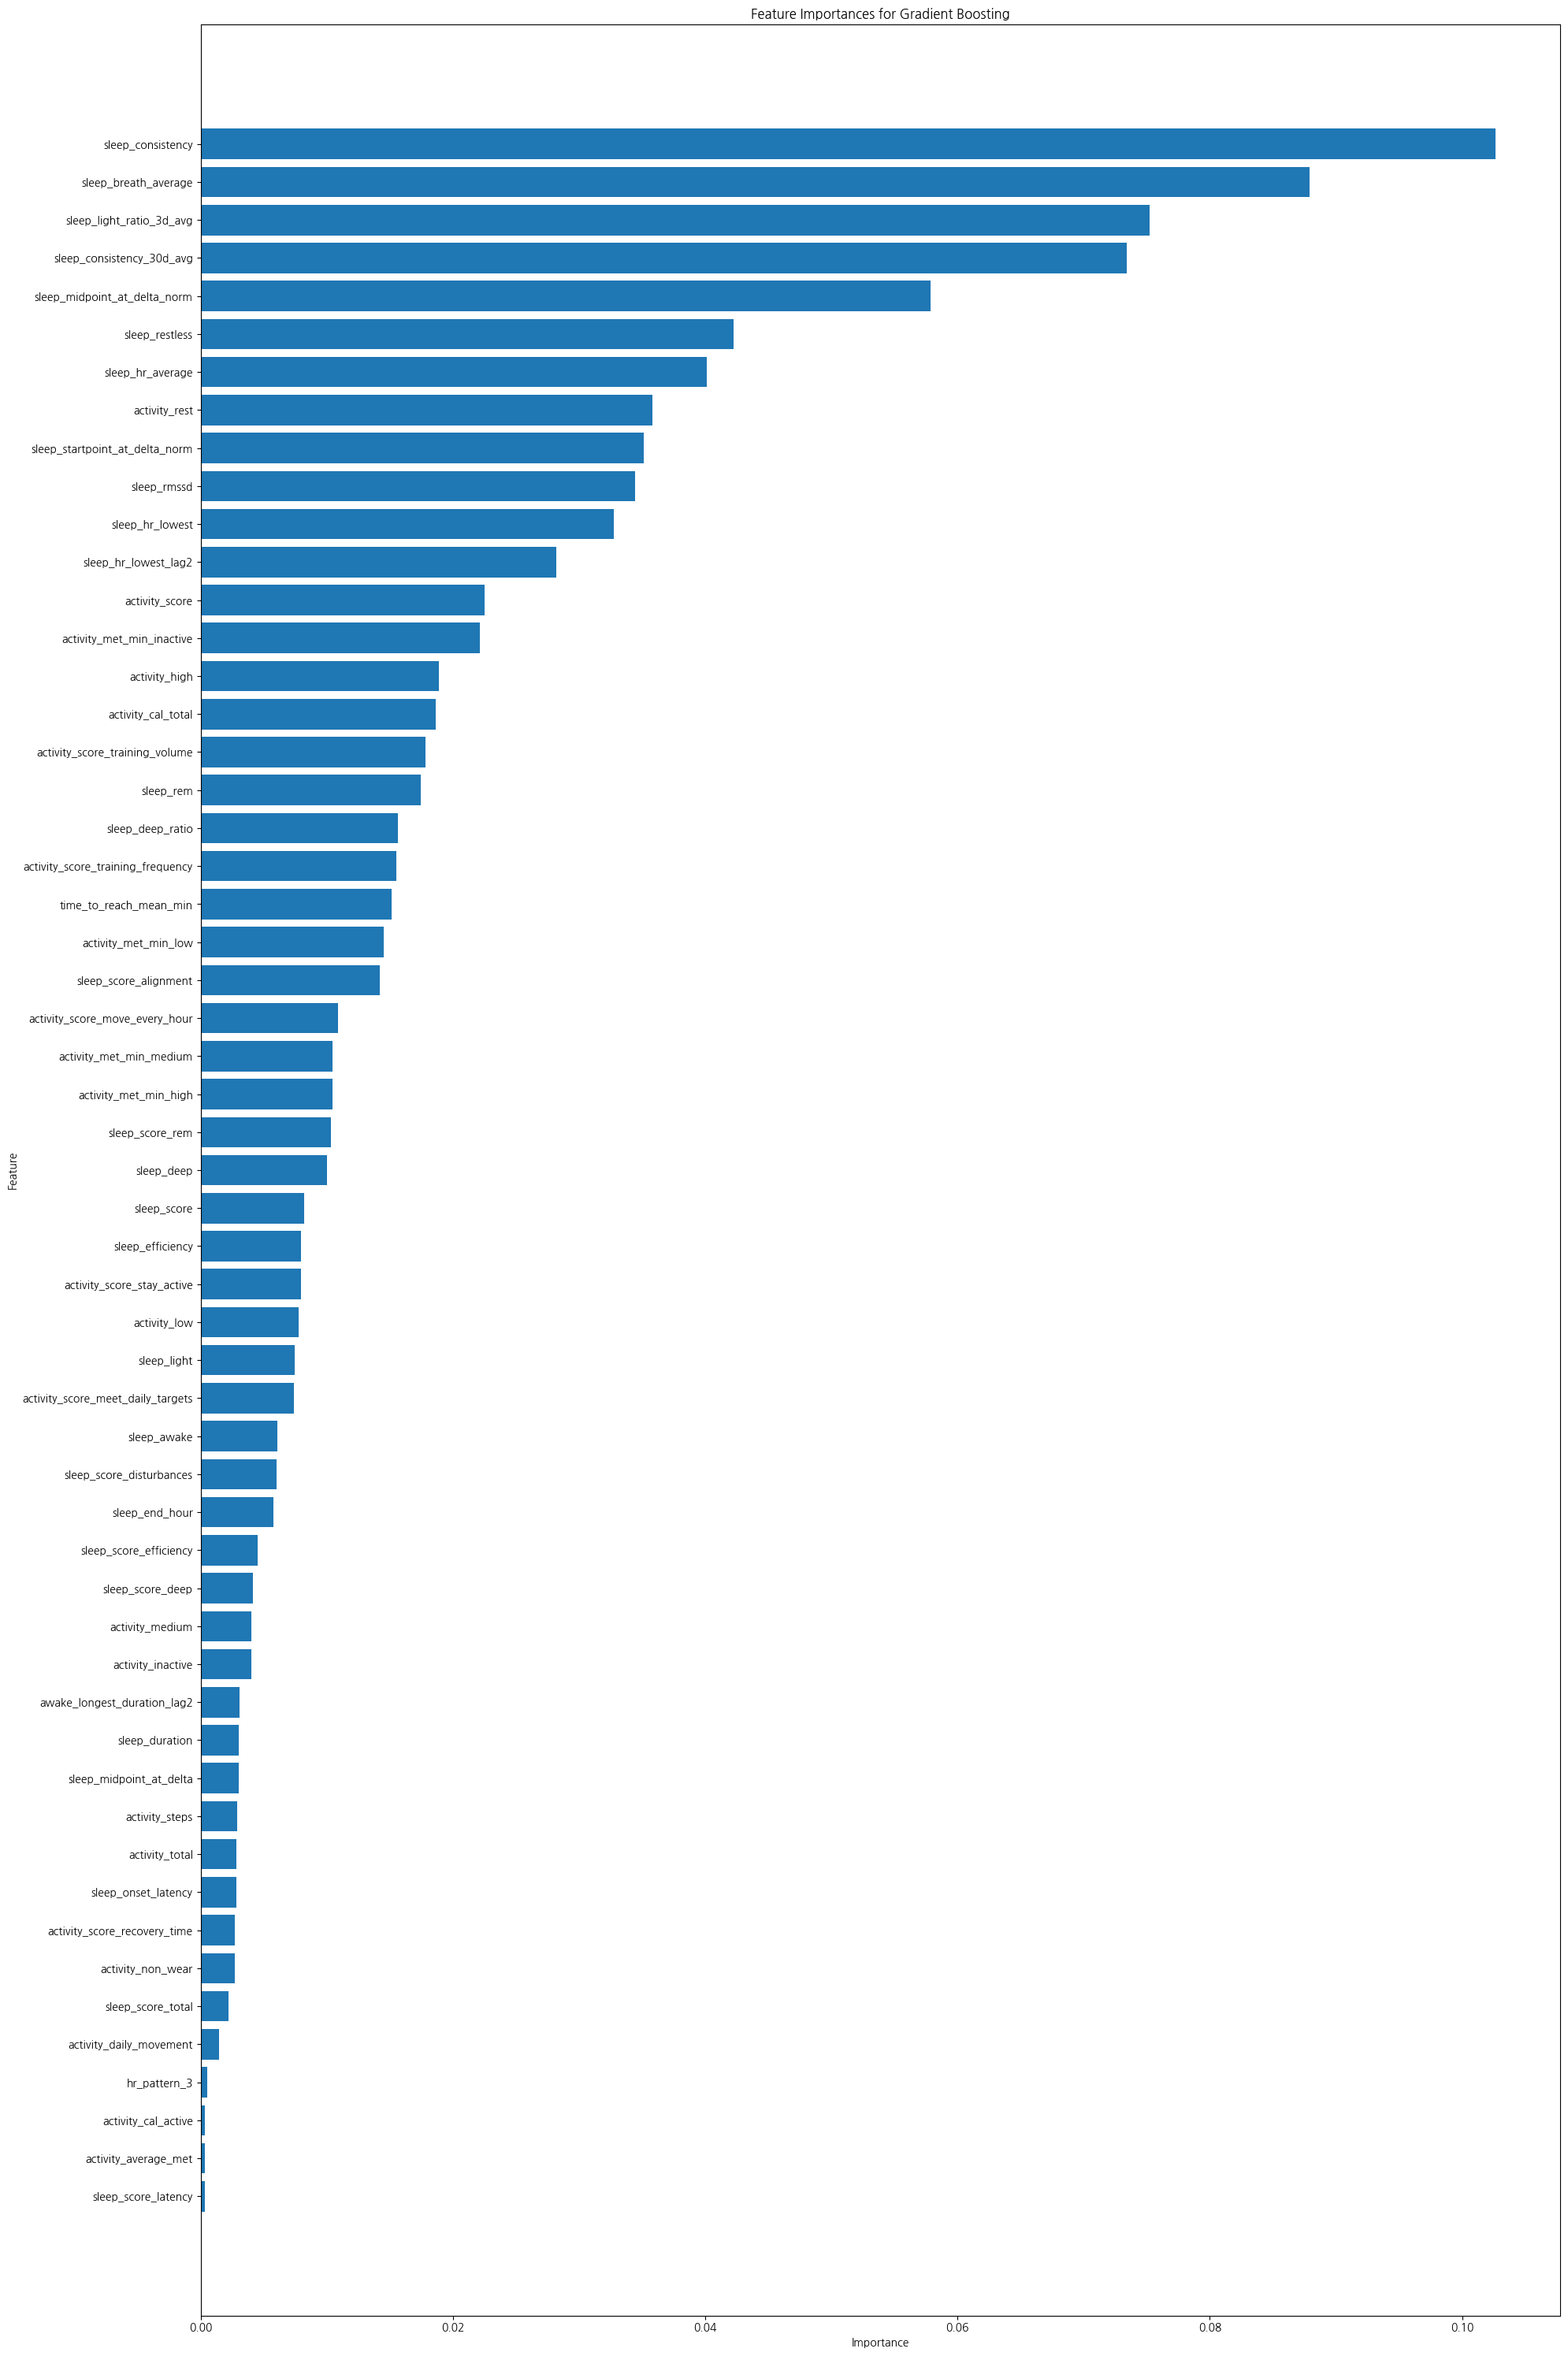

Low importance features for Gradient Boosting:
                              Feature  Importance
45                        sleep_score    0.008197
32                   sleep_efficiency    0.007977
18         activity_score_stay_active    0.007953
6                        activity_low    0.007752
37                        sleep_light    0.007452
15  activity_score_meet_daily_targets    0.007377
25                        sleep_awake    0.006072
48           sleep_score_disturbances    0.006005
33                     sleep_end_hour    0.005784
49             sleep_score_efficiency    0.004516
47                   sleep_score_deep    0.004122
7                     activity_medium    0.004054
5                   activity_inactive    0.004045
23        awake_longest_duration_lag2    0.003067
31                     sleep_duration    0.003026
39            sleep_midpoint_at_delta    0.003005
21                     activity_steps    0.002902
22                     activity_total    0.002847
41 

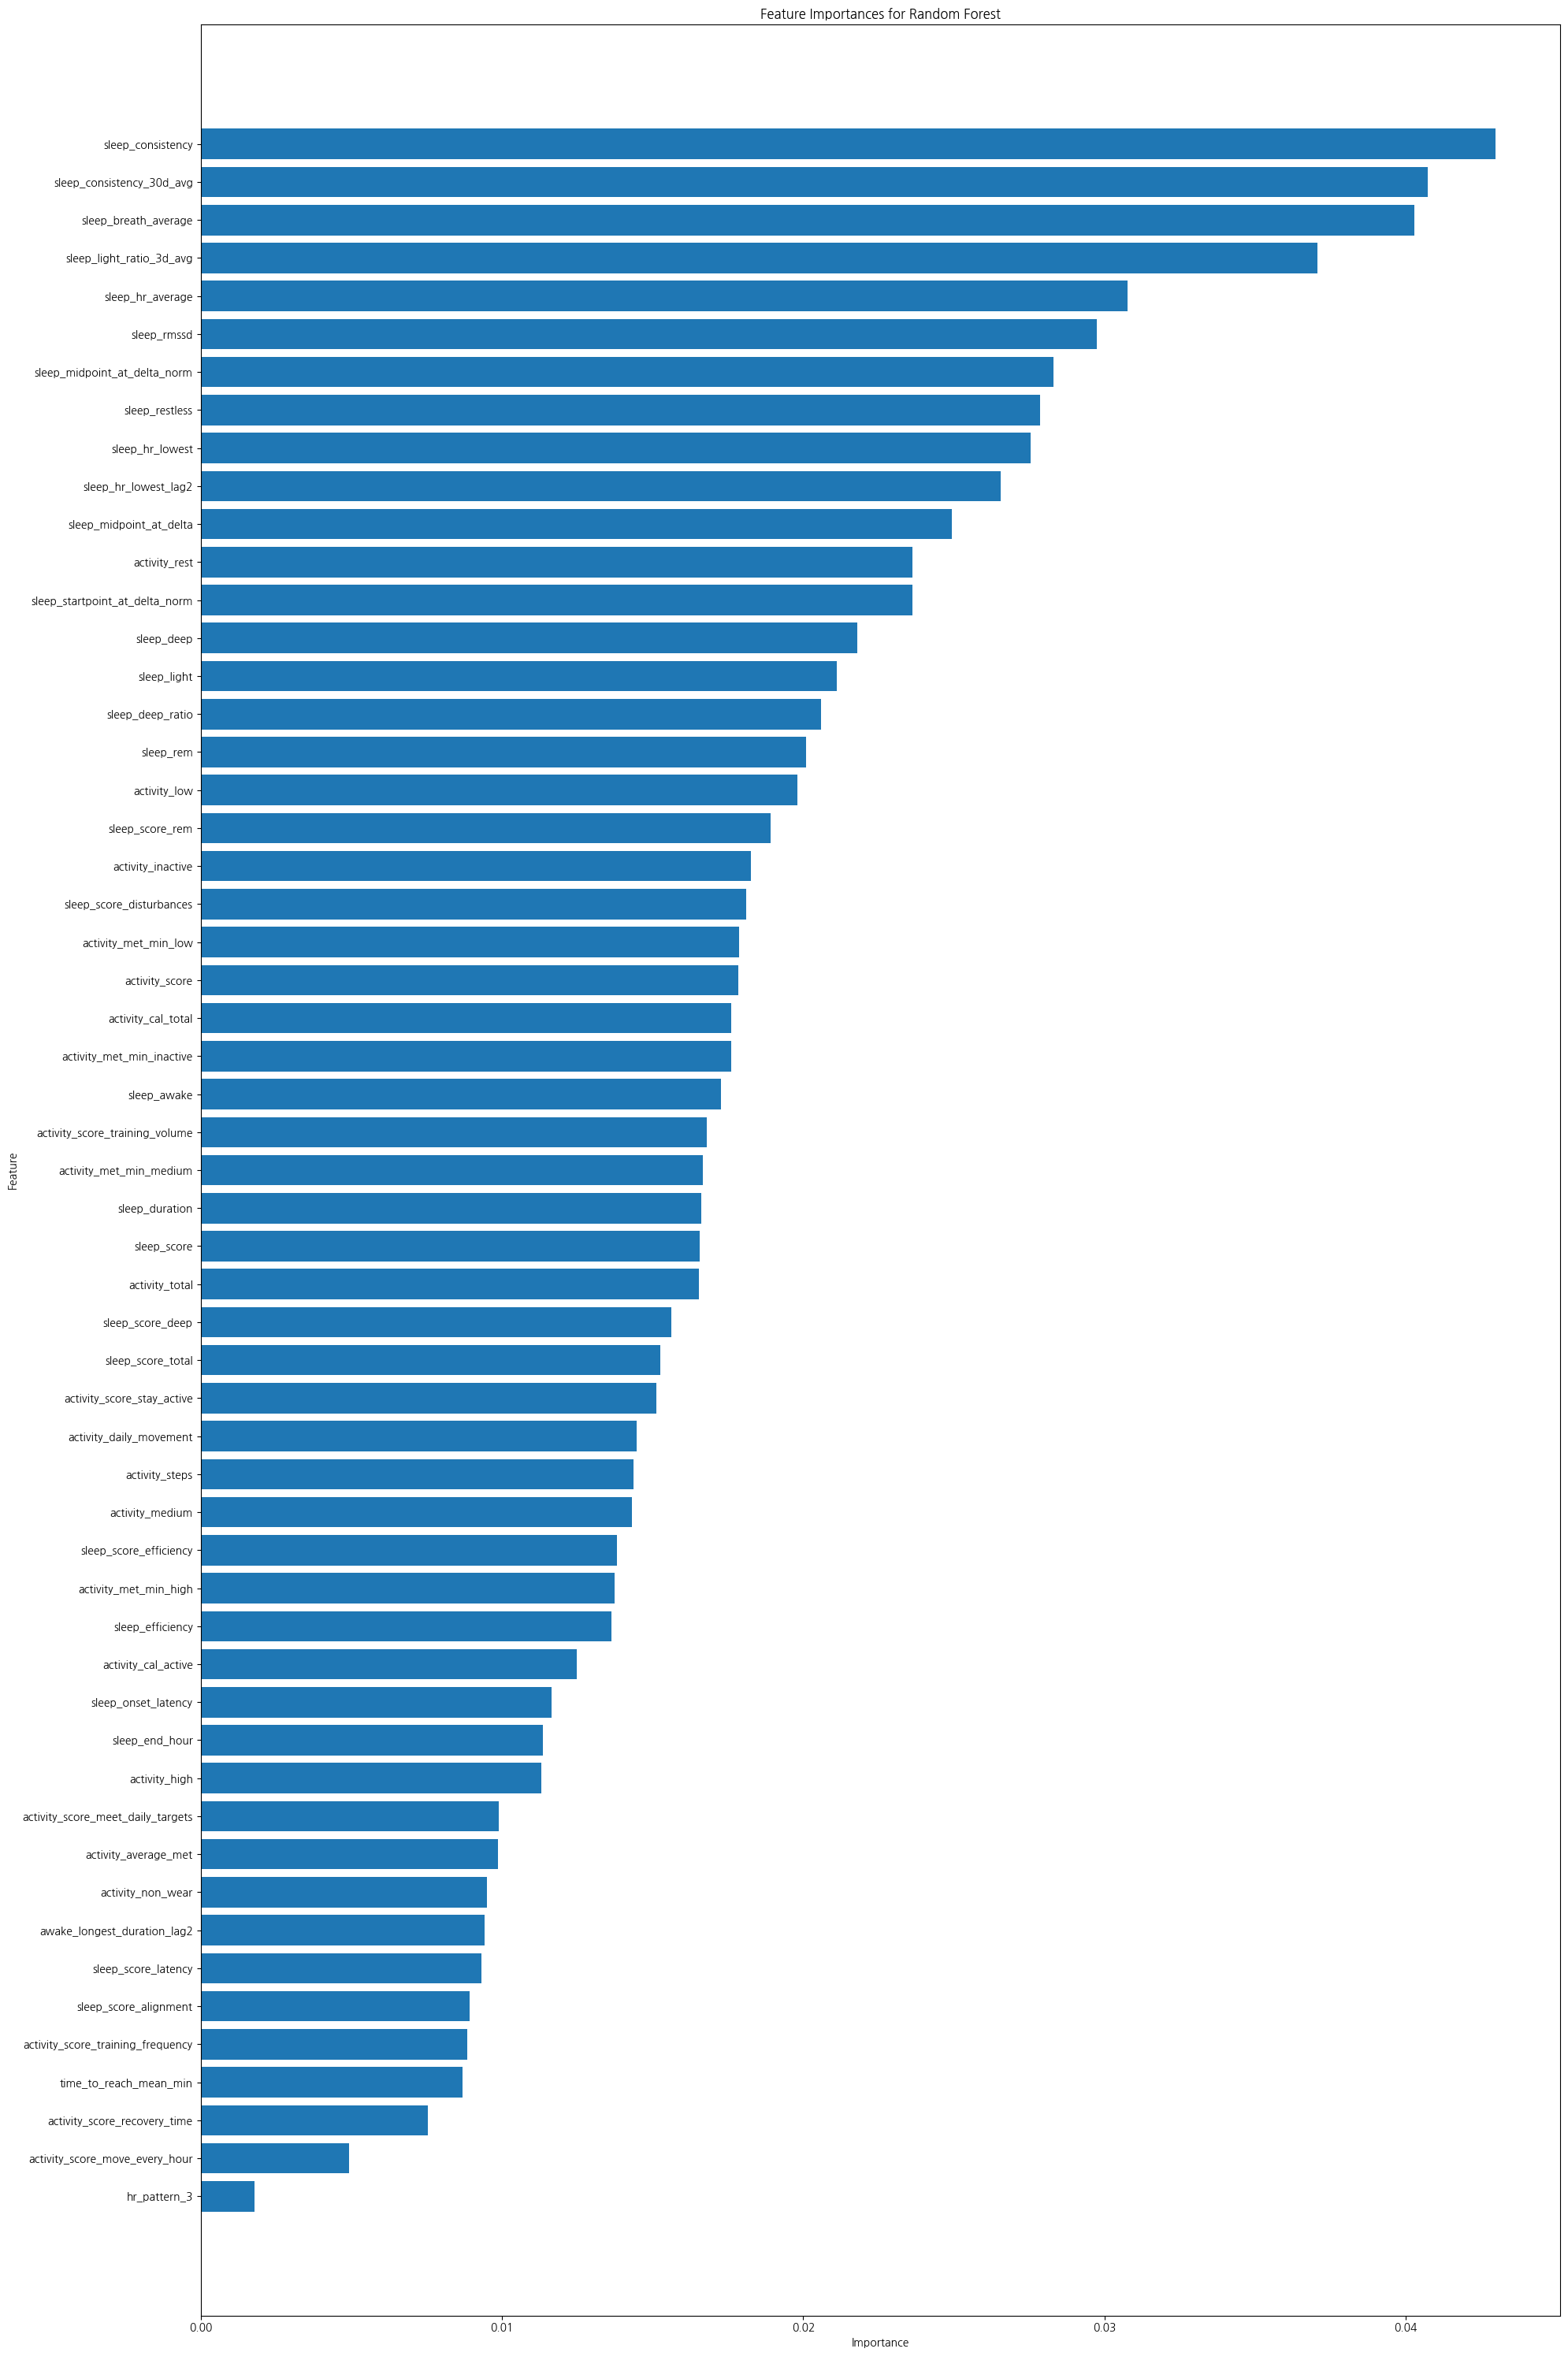

Low importance features for Random Forest:
                              Feature  Importance
15  activity_score_meet_daily_targets    0.009903
0                activity_average_met    0.009860
12                  activity_non_wear    0.009496
23        awake_longest_duration_lag2    0.009427
50                sleep_score_latency    0.009309
46              sleep_score_alignment    0.008939
19  activity_score_training_frequency    0.008844
54             time_to_reach_mean_min    0.008699
17       activity_score_recovery_time    0.007533
16     activity_score_move_every_hour    0.004933
24                       hr_pattern_3    0.001796


In [234]:
low_importances = []

for name, model in models_.items():
    if hasattr(model, "feature_importances_"):
        feature_importances = model.feature_importances_
        feature_names = merged_df.drop(["EMAIL", "label"], axis=1).columns
        importance_df = pd.DataFrame(
            {"Feature": feature_names, "Importance": feature_importances}
        )
        importance_df = importance_df.sort_values(by="Importance", ascending=False)

        plt.figure(figsize=(20, 30))  # 그래프 크기 조정
        plt.barh(importance_df["Feature"], importance_df["Importance"])
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.title(f"Feature Importances for {name}")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

        # 피처 중요도가 낮은 피처 확인
        low_importance_features = importance_df[importance_df["Importance"] < 0.01]
        low_importances.append(low_importance_features)
        print(f"Low importance features for {name}:")
        print(low_importance_features)

In [235]:
low_importances[0]["Feature"].values[-20:]

array(['sleep_score_disturbances', 'sleep_end_hour',
       'sleep_score_efficiency', 'sleep_score_deep', 'activity_medium',
       'activity_inactive', 'awake_longest_duration_lag2',
       'sleep_duration', 'sleep_midpoint_at_delta', 'activity_steps',
       'activity_total', 'sleep_onset_latency',
       'activity_score_recovery_time', 'activity_non_wear',
       'sleep_score_total', 'activity_daily_movement', 'hr_pattern_3',
       'activity_cal_active', 'activity_average_met',
       'sleep_score_latency'], dtype=object)

# 모델 저장

In [236]:
with open("case1_mode3", "wb") as f:
    pickle.dump(model_, f)